# Quantum Fourier Transform
### In this notebook we define the Quantum Fourier Transform (QFT) and implement it on a quantum computer. This operation is of great importance since it is at the heart of most quantum algorithms which provide significant speed-up over their classical counterparts.

## 1. Definition
### The QFT can be viewed as the quantum version of the discrete Fourier transform (DFT), which is already widely used in digital signal and image processing. The $N$-dimensional DFT is a unitary transformation which acts on a vector $\mathbf{x} = (x_0, \dots, x_{N-1})$ and maps it to the vector $\mathbf{y} = (y_0, \dots, y_{N-1})$, with the components related by: $$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\exp\left(\frac{2\pi i}{N}jk\right).$$
### Extending this definition analogously to the QFT (by simply using the ket vector notation), we arrive at the following unitary transformation $QFT_N$ acting on $n = \log_2(N)$ qubit states (we assume $N$ is an exact power of $2$): $$QFT_N\ket{x} = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\exp\left(\frac{2\pi i}{N}xy\right)\ket{y},$$
### where $\ket{x}$ is a computational basis state in the $n$-qubit vector space.

## 2. Computation of QFT
### The real benefit of using the QFT in quantum algorithms is that, despite representing a unitary transformation on a vector space with dimensionality which depends exponentially on the number of qubits, it can be performed using a polynomial number of operations. This is due to the fact that the output state of the transformation when acting on a computational basis state is a product state, which we will now prove. We can rewrite the equation above as so: $\begin{align}QFT_N\ket{x} &= \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\exp\left(\frac{2\pi i}{N}xy\right)\ket{y} \\ &= \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\exp\left(\frac{2\pi i}{2^n}xy\right)\ket{y} \\ &= \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\exp\left(2\pi ix\sum_{k=1}^{n}\frac{y_k}{2^k}\right)\ket{y = (y_1\dots y_n)_2} \\ &= \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\prod_{k=1}^n\exp\left(2\pi i x\frac{y_k}{2^k}\right)\ket{y = (y_1\dots y_n)_2} \\ &= \frac{1}{\sqrt{N}}\prod_{k=1}^n\left(\ket{0}_k + \exp\left(2\pi ix\frac{1}{2^k}\right)\ket{1}_k\right) \\ &= \frac{1}{\sqrt{N}}\left(\ket{0} + \exp\left(2\pi ix\frac{1}{2}\right)\ket{1}\right)\otimes\dots\otimes\left(\ket{0} + \exp\left(2\pi ix\frac{1}{2^n}\right)\ket{1}\right)\end{align}$

### The way to implement this product-to-product state transformation is through the following steps. Let us have the state $\ket{x} = \ket{x_1\dots x_n}$. We apply a Hadamard transform to the left-most qubit, which we will specify as the first from now on, and get the state $$\hat{H}_1\ket{x_1\dots x_n} = \frac{1}{\sqrt{2}}\big(\ket{0} + (-1)^{x_1} \ket{1}\big)\ket{x_2\dots x_n} = \frac{1}{\sqrt{2}}\left(\ket{0} + \exp\left(2\pi i\frac{x_1}{2}\right)\ket{1}\right)\ket{x_2\dots x_n}.$$

### We then apply a controled phase rotation (CP) gate with the second qubit as the control and the first as the target. The angle of the phase rotation is $\theta_n = \frac{2\pi}{2^n}$ with $n=2.$ This transforms the state into $$CP^1_2(\theta_2)\hat{H}_1\ket{x_1\dots x_n} = \frac{1}{\sqrt{2}}\left(\ket{0} + \exp\left(2\pi i\frac{x_1}{2} + 2\pi i\frac{x_2}{2^2}\right)\ket{1}\right)\ket{x_2\dots x_n}.$$

### Repeating this process using each of the remaining qubits as the control qubit for a CP gate with the first qubit as the target, we get the state $\begin{align}CP^1_n(\theta_n)\dots CP^1_2(\theta_2)\hat{H}_1\ket{x_1\dots x_n} &= \frac{1}{\sqrt{2}}\left(\ket{0} + \exp\left(2\pi i\frac{x_1}{2} + \dots + 2\pi i\frac{x_n}{2^n}\right)\ket{1}\right)\ket{x_2\dots x_n}\\ &= \frac{1}{\sqrt{2}}\left(\ket{0} + \exp\left(2\pi ix\frac{1}{2^n}\right)\ket{1}\right)\ket{x_2\dots x_n},\end{align}$ where we have used that $x = x_12^{n-1} + \dots + x_n2^0.$ We see that the first qubit state is exactly the same as the last qubit state in the mathematical manipulation of the QFT above. To get the remaining qubits into the corresponding states, we repeat the operation described in an analogous way. To illustrate for the second qubit in $\ket{x}$, we apply a Hadamard transform to it, followed by $n-2$ CP gates with each of the remaining qubits as control gates in turn. This will generate the second-to-last qubit in the manipulation from before.
### Overall, we get the correct state using this approach, but with the qubits in reverse order. Hence, we just need to apply $\left\lfloor{\frac{n}{2}}\right\rfloor$ swap operations. The total number of gates we need to apply is $n + (n-1) + \dots + 1 + 3\left\lfloor{\frac{n}{2}}\right\rfloor = O(n^2)$.

## 3. Implementation of the Quantum Fourier Transform

In [1]:
# import relevant libraries
import numpy as np
import math

from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.extensions import Initialize

In [109]:
# define method which return quantum circuit performing QFT
def QFT_circuit(no_qubits):
    result = QuantumCircuit(no_qubits)
    qubit = no_qubits - 1
    while qubit >= 0:
        result.h(qubit)
        control_qubit_cp = qubit - 1
        while control_qubit_cp >= 0:
            phase = 2 * math.pi / (2**(qubit + 1 - control_qubit_cp))
            result.cp(phase, control_qubit=control_qubit_cp, target_qubit=qubit)
            control_qubit_cp = control_qubit_cp - 1
        qubit = qubit - 1
        result.barrier()
    qubit = 0
    while qubit < no_qubits//2:
        result.swap(qubit, no_qubits - 1 - qubit)
        qubit = qubit + 1
    return result

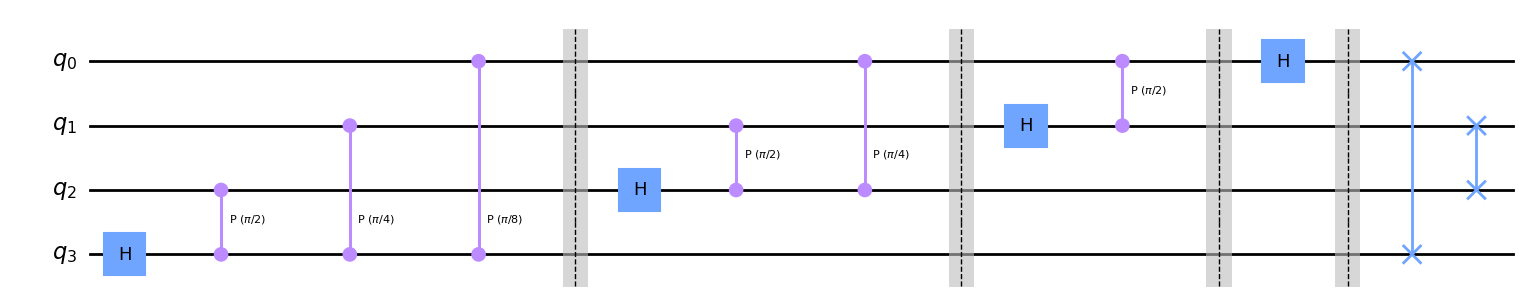

In [110]:
# demonstrate circuit creation for 4 qubits
QFT_4 = QFT_circuit(4)
QFT_4.draw(output='mpl')

In [112]:
# check if the quantum circuit works
no_qubits = 4
period = 2

num = 0
total_state = None
while num < 2**no_qubits:
    initial_state = Statevector.from_int(num, dims=2**no_qubits)
    if total_state == None:
        total_state = initial_state
    else:
        total_state = total_state + initial_state
    num = num + period
# normalise the state
total_state = total_state / math.sqrt(total_state.inner(total_state))
display(total_state.draw(output='latex'))

/var/folders/kd/p2pqbh9n41d6x0bm8p7p9dd00000gn/T/ipykernel_6070/849125177.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  total_state = total_state / math.sqrt(total_state.inner(total_state))


<IPython.core.display.Latex object>

/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


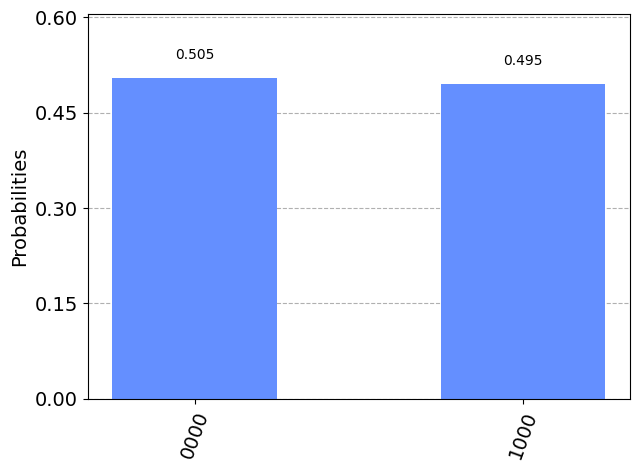

In [113]:
simulator = Aer.get_backend("aer_simulator")
initialiser = Initialize(total_state)
initialiser.label = "Initialiser"
qc = QuantumCircuit(no_qubits)
qc.append(initialiser, [i for i in range(no_qubits)])
qc.append(QFT_circuit(no_qubits), [i for i in range(no_qubits)])
qc.measure_all()
transpiled_circuit = transpile(qc, simulator)
result = simulator.run(transpiled_circuit).result().get_counts()
plot_histogram(result)

### We get $4$ uniformly distributed states in increments of $\frac{N}{r} = \frac{2^4}{2} = 8 = 2^3 = 1000_2$, exactly as expected.

In [114]:
# let's run the circuit on a real quantum device
IBMQ.load_account()
provider = IBMQ.get_provider(hub ='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= no_qubits and not x.configuration().simulator and x.status().operational==True))
print("Least busy backend:", backend)

ibmqfactory.load_account:WARNING:2022-09-15 11:44:40,189: Credentials are already in use. The existing account in the session will be replaced.


Least busy backend: ibmq_belem


In [115]:
shots = 2048
transpiled_circuit = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_circuit, shots=shots)
job_monitor(job)

Job Status: job is queued (10)    

In [2]:
counts = job.result().get_counts()
plot_histogram(counts)

NameError: name 'job' is not defined